In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import gym
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.patches as patches

class Qfunction(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.linear_1 = nn.Linear(state_dim, 64)
        self.linear_2 = nn.Linear(64, 64)
        self.linear_3 = nn.Linear(64, action_dim)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, states):
        hidden = self.linear_1(states)
        hidden = self.activation(hidden)
        hidden = self.linear_2(hidden)
        hidden = self.activation(hidden)
        actions = self.linear_3(hidden)
        return actions

In [2]:
%matplotlib inline

In [3]:
env = gym.make('LunarLander-v2',continuous = True)

In [9]:
class SDQN:
    def __init__(self, state_dim, action_dim, gamma=0.993, lr=1e-3, batch_size=128, epsilon_decrease=0.01, epsilon_min=0.03):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_function = Qfunction(self.state_dim, self.action_dim)
        self.q_function_ = Qfunction(self.state_dim, self.action_dim)
        for target_param in self.q_function_.parameters():
            target_param.data.copy_(target_param.data)
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = 1
        self.epsilon_decrease = epsilon_decrease
        self.epsilon_min = epsilon_min
        self.memory = []
        self.memory_lim = 150000
        self.optimzaer = torch.optim.Adam(self.q_function.parameters(), lr=lr)

    def get_action(self, state, target= False):
        if(target):
            q_values = self.q_function_(torch.FloatTensor(state))
        else:
            q_values = self.q_function(torch.FloatTensor(state))
        argmax_action = torch.argmax(q_values,dim=-1)
        probs = self.epsilon * np.ones((argmax_action.shape[0],self.action_dim)) / self.action_dim
        probs[np.arange(argmax_action.shape[0]),argmax_action] += 1 - self.epsilon
        action = np.ones(q_values.shape[0], dtype=np.int32)
        for sample in range(q_values.shape[0]):
            action[sample] = np.random.choice(np.arange(self.action_dim), p=probs[sample,:])
        return action
    
    def fit(self, state, action, reward, done, next_state, tau):
        self.memory.append([state, action, reward, int(done), next_state])
        if(len(self.memory)>self.memory_lim):
            self.memory = self.memory[int(self.memory_lim*0.05):]
            self.memory = random.sample(self.memory, int(self.memory_lim*0.9))
            print('clear memory')
        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.tensor, list(zip(*batch)))
    
            targets = rewards + self.gamma * (1 - dones) * torch.max(self.q_function_(next_states), dim=1).values
            q_values = self.q_function(states)[torch.arange(self.batch_size), actions]
            
            loss = torch.mean((q_values - targets.detach()) ** 2)
            loss.backward()
            self.optimzaer.step()
            self.optimzaer.zero_grad()
            
            self.soft_update(self.q_function,self.q_function_, tau)
            
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decrease
                
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [10]:
%%time
state_dim = env.observation_space.shape[0]
action_dim = 6

episode_n = 1000
t_max = 1000

agent_s = SDQN(state_dim, action_dim,epsilon_decrease=0.03/2000)
action_dict = [[0,0],[1,0],[1,-1],[1,1],[0,1],[0,-1]]

hist_s = []
hist_s_v = []
hist_s_v_disc = []
hist_s_v_ = []
hist_s_v_disc_ = []

for episode in range(episode_n):
    total_reward = 0

    state = env.reset()
    for t in range(t_max):
        action = agent_s.get_action([state])
        next_state, reward, done, _ = env.step(action_dict[action[0]])

        total_reward += reward
        agent_s.fit(state, int(action), reward, done, next_state,tau = 0.005)

        state = next_state

        if done:
            break
    
    hist_s.append(total_reward)
    
    #validate
    if(episode%10 == 0):
        eps = agent_s.epsilon
        agent_s.epsilon = 0
        total_reward = 0
        total_reward_disc = 0
        rew_mult = 1
        state = env.reset()
        for t in range(t_max):
            action = agent_s.get_action([state], True)
            next_state, reward, done, _ = env.step(action_dict[action[0]])

            total_reward += reward
            
            total_reward_disc += rew_mult*reward
            rew_mult *= agent_s.gamma

            state = next_state

            if done:
                break
        agent_s.epsilon = eps
        
        hist_s_v_.append(total_reward)
        hist_s_v_disc_.append(total_reward_disc)
        
    
    if(episode%10 == 0):
        eps = agent_s.epsilon
        agent_s.epsilon = 0
        total_reward = 0
        total_reward_disc = 0
        rew_mult = 1
        state = env.reset()
        for t in range(t_max):
            action = agent_s.get_action([state], False)
            next_state, reward, done, _ = env.step(action_dict[action[0]])

            total_reward += reward
            
            total_reward_disc += rew_mult*reward
            rew_mult *= agent_s.gamma

            state = next_state

            if done:
                break
        agent_s.epsilon = eps
        
        hist_s_v.append(total_reward)
        hist_s_v_disc.append(total_reward_disc)

    print(f'episode: {episode}, \
rew: {round(np.mean(hist_s[-100:]),2)}, \
v_: {round(np.mean(hist_s_v_[-10:]),2)}, \
v_disc_: {round(np.mean(hist_s_v_disc_[-10:]),2)}, \
v: {round(np.mean(hist_s_v[-10:]),2)}, \
v_disc: {round(np.mean(hist_s_v_disc[-10:]),2)}, \
epsilon: {round(agent_s.epsilon,2)}, \
mem: {len(agent_s.memory)}')

episode: 0, rew: -561.9, v_: -1815.2, v_disc_: -911.33, v: -111.37, v_disc: -71.87, epsilon: 1.0, mem: 234
episode: 1, rew: -554.68, v_: -1815.2, v_disc_: -911.33, v: -111.37, v_disc: -71.87, epsilon: 1.0, mem: 433
episode: 2, rew: -383.23, v_: -1815.2, v_disc_: -911.33, v: -111.37, v_disc: -71.87, epsilon: 0.99, mem: 560
episode: 3, rew: -379.05, v_: -1815.2, v_disc_: -911.33, v: -111.37, v_disc: -71.87, epsilon: 0.99, mem: 637
episode: 4, rew: -379.72, v_: -1815.2, v_disc_: -911.33, v: -111.37, v_disc: -71.87, epsilon: 0.99, mem: 746
episode: 5, rew: -378.25, v_: -1815.2, v_disc_: -911.33, v: -111.37, v_disc: -71.87, epsilon: 0.99, mem: 906
episode: 6, rew: -373.57, v_: -1815.2, v_disc_: -911.33, v: -111.37, v_disc: -71.87, epsilon: 0.99, mem: 998
episode: 7, rew: -351.44, v_: -1815.2, v_disc_: -911.33, v: -111.37, v_disc: -71.87, epsilon: 0.99, mem: 1097
episode: 8, rew: -372.7, v_: -1815.2, v_disc_: -911.33, v: -111.37, v_disc: -71.87, epsilon: 0.98, mem: 1258
episode: 9, rew: -337

episode: 75, rew: -260.32, v_: -360.99, v_disc_: -172.45, v: -176.73, v_disc: -44.62, epsilon: 0.84, mem: 10954
episode: 76, rew: -258.39, v_: -360.99, v_disc_: -172.45, v: -176.73, v_disc: -44.62, epsilon: 0.84, mem: 11116
episode: 77, rew: -256.3, v_: -360.99, v_disc_: -172.45, v: -176.73, v_disc: -44.62, epsilon: 0.83, mem: 11235
episode: 78, rew: -254.65, v_: -360.99, v_disc_: -172.45, v: -176.73, v_disc: -44.62, epsilon: 0.83, mem: 11576
episode: 79, rew: -258.0, v_: -360.99, v_disc_: -172.45, v: -176.73, v_disc: -44.62, epsilon: 0.83, mem: 11704
episode: 80, rew: -257.5, v_: -334.44, v_disc_: -163.4, v: -167.66, v_disc: -46.92, epsilon: 0.82, mem: 11802
episode: 81, rew: -258.05, v_: -334.44, v_disc_: -163.4, v: -167.66, v_disc: -46.92, epsilon: 0.82, mem: 11925
episode: 82, rew: -256.82, v_: -334.44, v_disc_: -163.4, v: -167.66, v_disc: -46.92, epsilon: 0.82, mem: 12081
episode: 83, rew: -255.16, v_: -334.44, v_disc_: -163.4, v: -167.66, v_disc: -46.92, epsilon: 0.82, mem: 12219

episode: 149, rew: -223.91, v_: -157.75, v_disc_: -99.8, v: -162.84, v_disc: -104.86, epsilon: 0.71, mem: 19537
episode: 150, rew: -221.98, v_: -170.16, v_disc_: -111.0, v: -165.3, v_disc: -109.37, epsilon: 0.71, mem: 19648
episode: 151, rew: -224.91, v_: -170.16, v_disc_: -111.0, v: -165.3, v_disc: -109.37, epsilon: 0.71, mem: 19730
episode: 152, rew: -224.73, v_: -170.16, v_disc_: -111.0, v: -165.3, v_disc: -109.37, epsilon: 0.7, mem: 19813
episode: 153, rew: -224.29, v_: -170.16, v_disc_: -111.0, v: -165.3, v_disc: -109.37, epsilon: 0.7, mem: 19926
episode: 154, rew: -225.19, v_: -170.16, v_disc_: -111.0, v: -165.3, v_disc: -109.37, epsilon: 0.7, mem: 20017
episode: 155, rew: -228.39, v_: -170.16, v_disc_: -111.0, v: -165.3, v_disc: -109.37, epsilon: 0.7, mem: 20159
episode: 156, rew: -226.58, v_: -170.16, v_disc_: -111.0, v: -165.3, v_disc: -109.37, epsilon: 0.7, mem: 20233
episode: 157, rew: -225.07, v_: -170.16, v_disc_: -111.0, v: -165.3, v_disc: -109.37, epsilon: 0.7, mem: 2032

episode: 222, rew: -227.23, v_: -215.21, v_disc_: -120.15, v: -131.5, v_disc: -75.93, epsilon: 0.41, mem: 39415
episode: 223, rew: -226.1, v_: -215.21, v_disc_: -120.15, v: -131.5, v_disc: -75.93, epsilon: 0.4, mem: 40415
episode: 224, rew: -222.88, v_: -215.21, v_disc_: -120.15, v: -131.5, v_disc: -75.93, epsilon: 0.38, mem: 41415
episode: 225, rew: -220.57, v_: -215.21, v_disc_: -120.15, v: -131.5, v_disc: -75.93, epsilon: 0.37, mem: 42415
episode: 226, rew: -218.72, v_: -215.21, v_disc_: -120.15, v: -131.5, v_disc: -75.93, epsilon: 0.35, mem: 43415
episode: 227, rew: -213.78, v_: -215.21, v_disc_: -120.15, v: -131.5, v_disc: -75.93, epsilon: 0.34, mem: 44415
episode: 228, rew: -213.57, v_: -215.21, v_disc_: -120.15, v: -131.5, v_disc: -75.93, epsilon: 0.32, mem: 45415
episode: 229, rew: -211.25, v_: -215.21, v_disc_: -120.15, v: -131.5, v_disc: -75.93, epsilon: 0.31, mem: 46415
episode: 230, rew: -209.95, v_: -188.2, v_disc_: -98.68, v: -107.46, v_disc: -53.22, epsilon: 0.29, mem: 4

episode: 297, rew: -75.67, v_: -67.57, v_disc_: 5.89, v: -51.65, v_disc: 20.49, epsilon: 0.03, mem: 100481
episode: 298, rew: -74.88, v_: -67.57, v_disc_: 5.89, v: -51.65, v_disc: 20.49, epsilon: 0.03, mem: 101481
episode: 299, rew: -74.45, v_: -67.57, v_disc_: 5.89, v: -51.65, v_disc: 20.49, epsilon: 0.03, mem: 102481
episode: 300, rew: -73.14, v_: -64.37, v_disc_: 14.54, v: -54.47, v_disc: 28.38, epsilon: 0.03, mem: 103481
episode: 301, rew: -74.78, v_: -64.37, v_disc_: 14.54, v: -54.47, v_disc: 28.38, epsilon: 0.03, mem: 104063
episode: 302, rew: -76.6, v_: -64.37, v_disc_: 14.54, v: -54.47, v_disc: 28.38, epsilon: 0.03, mem: 104526
episode: 303, rew: -76.5, v_: -64.37, v_disc_: 14.54, v: -54.47, v_disc: 28.38, epsilon: 0.03, mem: 105526
episode: 304, rew: -78.89, v_: -64.37, v_disc_: 14.54, v: -54.47, v_disc: 28.38, epsilon: 0.03, mem: 106263
episode: 305, rew: -80.1, v_: -64.37, v_disc_: 14.54, v: -54.47, v_disc: 28.38, epsilon: 0.03, mem: 106844
episode: 306, rew: -80.48, v_: -64

episode: 373, rew: -109.03, v_: -149.58, v_disc_: 6.77, v: -109.85, v_disc: -6.02, epsilon: 0.03, mem: 140516
episode: 374, rew: -111.55, v_: -149.58, v_disc_: 6.77, v: -109.85, v_disc: -6.02, epsilon: 0.03, mem: 141516
episode: 375, rew: -113.08, v_: -149.58, v_disc_: 6.77, v: -109.85, v_disc: -6.02, epsilon: 0.03, mem: 142516
episode: 376, rew: -112.2, v_: -149.58, v_disc_: 6.77, v: -109.85, v_disc: -6.02, epsilon: 0.03, mem: 143516
episode: 377, rew: -111.44, v_: -149.58, v_disc_: 6.77, v: -109.85, v_disc: -6.02, epsilon: 0.03, mem: 144516
episode: 378, rew: -108.78, v_: -149.58, v_disc_: 6.77, v: -109.85, v_disc: -6.02, epsilon: 0.03, mem: 145516
episode: 379, rew: -107.74, v_: -149.58, v_disc_: 6.77, v: -109.85, v_disc: -6.02, epsilon: 0.03, mem: 146516
episode: 380, rew: -107.57, v_: -141.79, v_disc_: 9.0, v: -88.84, v_disc: 0.45, epsilon: 0.03, mem: 147516
episode: 381, rew: -102.51, v_: -141.79, v_disc_: 9.0, v: -88.84, v_disc: 0.45, epsilon: 0.03, mem: 148313
episode: 382, rew

episode: 449, rew: 7.15, v_: -57.75, v_disc_: 25.01, v: -108.19, v_disc: 6.84, epsilon: 0.03, mem: 138293
episode: 450, rew: 11.04, v_: -34.52, v_disc_: 26.37, v: -80.98, v_disc: 16.4, epsilon: 0.03, mem: 138615
episode: 451, rew: 14.54, v_: -34.52, v_disc_: 26.37, v: -80.98, v_disc: 16.4, epsilon: 0.03, mem: 139601
episode: 452, rew: 17.64, v_: -34.52, v_disc_: 26.37, v: -80.98, v_disc: 16.4, epsilon: 0.03, mem: 140225
episode: 453, rew: 20.05, v_: -34.52, v_disc_: 26.37, v: -80.98, v_disc: 16.4, epsilon: 0.03, mem: 140899
episode: 454, rew: 23.59, v_: -34.52, v_disc_: 26.37, v: -80.98, v_disc: 16.4, epsilon: 0.03, mem: 141335
episode: 455, rew: 28.17, v_: -34.52, v_disc_: 26.37, v: -80.98, v_disc: 16.4, epsilon: 0.03, mem: 141895
episode: 456, rew: 30.06, v_: -34.52, v_disc_: 26.37, v: -80.98, v_disc: 16.4, epsilon: 0.03, mem: 142895
episode: 457, rew: 33.92, v_: -34.52, v_disc_: 26.37, v: -80.98, v_disc: 16.4, epsilon: 0.03, mem: 143418
episode: 458, rew: 37.66, v_: -34.52, v_disc_:

episode: 526, rew: 137.09, v_: 48.54, v_disc_: 52.52, v: -40.94, v_disc: 45.26, epsilon: 0.03, mem: 139225
episode: 527, rew: 140.1, v_: 48.54, v_disc_: 52.52, v: -40.94, v_disc: 45.26, epsilon: 0.03, mem: 139705
episode: 528, rew: 140.0, v_: 48.54, v_disc_: 52.52, v: -40.94, v_disc: 45.26, epsilon: 0.03, mem: 140705
episode: 529, rew: 143.0, v_: 48.54, v_disc_: 52.52, v: -40.94, v_disc: 45.26, epsilon: 0.03, mem: 141257
episode: 530, rew: 146.18, v_: 71.55, v_disc_: 53.52, v: 41.4, v_disc: 47.74, epsilon: 0.03, mem: 141591
episode: 531, rew: 148.1, v_: 71.55, v_disc_: 53.52, v: 41.4, v_disc: 47.74, epsilon: 0.03, mem: 142553
episode: 532, rew: 150.79, v_: 71.55, v_disc_: 53.52, v: 41.4, v_disc: 47.74, epsilon: 0.03, mem: 143044
episode: 533, rew: 150.16, v_: 71.55, v_disc_: 53.52, v: 41.4, v_disc: 47.74, epsilon: 0.03, mem: 143538
episode: 534, rew: 153.0, v_: 71.55, v_disc_: 53.52, v: 41.4, v_disc: 47.74, epsilon: 0.03, mem: 143950
episode: 535, rew: 155.48, v_: 71.55, v_disc_: 53.52

episode: 604, rew: 123.26, v_: 104.09, v_disc_: 29.74, v: 67.39, v_disc: 16.49, epsilon: 0.03, mem: 144768
episode: 605, rew: 123.14, v_: 104.09, v_disc_: 29.74, v: 67.39, v_disc: 16.49, epsilon: 0.03, mem: 145540
episode: 606, rew: 123.27, v_: 104.09, v_disc_: 29.74, v: 67.39, v_disc: 16.49, epsilon: 0.03, mem: 145877
episode: 607, rew: 123.49, v_: 104.09, v_disc_: 29.74, v: 67.39, v_disc: 16.49, epsilon: 0.03, mem: 146228
episode: 608, rew: 123.11, v_: 104.09, v_disc_: 29.74, v: 67.39, v_disc: 16.49, epsilon: 0.03, mem: 146857
episode: 609, rew: 123.89, v_: 104.09, v_disc_: 29.74, v: 67.39, v_disc: 16.49, epsilon: 0.03, mem: 147168
episode: 610, rew: 124.23, v_: 127.18, v_disc_: 23.63, v: 94.43, v_disc: 21.28, epsilon: 0.03, mem: 147585
episode: 611, rew: 130.57, v_: 127.18, v_disc_: 23.63, v: 94.43, v_disc: 21.28, epsilon: 0.03, mem: 148291
episode: 612, rew: 130.58, v_: 127.18, v_disc_: 23.63, v: 94.43, v_disc: 21.28, epsilon: 0.03, mem: 148735
episode: 613, rew: 129.34, v_: 127.18

episode: 681, rew: 172.46, v_: 158.46, v_disc_: 30.97, v: 105.6, v_disc: 31.85, epsilon: 0.03, mem: 148563
episode: 682, rew: 172.57, v_: 158.46, v_disc_: 30.97, v: 105.6, v_disc: 31.85, epsilon: 0.03, mem: 148750
episode: 683, rew: 174.89, v_: 158.46, v_disc_: 30.97, v: 105.6, v_disc: 31.85, epsilon: 0.03, mem: 149292
episode: 684, rew: 174.55, v_: 158.46, v_disc_: 30.97, v: 105.6, v_disc: 31.85, epsilon: 0.03, mem: 149645
clear memory
episode: 685, rew: 174.53, v_: 158.46, v_disc_: 30.97, v: 105.6, v_disc: 31.85, epsilon: 0.03, mem: 135225
episode: 686, rew: 175.24, v_: 158.46, v_disc_: 30.97, v: 105.6, v_disc: 31.85, epsilon: 0.03, mem: 135625
episode: 687, rew: 175.24, v_: 158.46, v_disc_: 30.97, v: 105.6, v_disc: 31.85, epsilon: 0.03, mem: 135986
episode: 688, rew: 174.87, v_: 158.46, v_disc_: 30.97, v: 105.6, v_disc: 31.85, epsilon: 0.03, mem: 136506
episode: 689, rew: 174.68, v_: 158.46, v_disc_: 30.97, v: 105.6, v_disc: 31.85, epsilon: 0.03, mem: 136942
episode: 690, rew: 175.0

episode: 758, rew: 207.12, v_: 201.96, v_disc_: 51.76, v: 95.18, v_disc: 51.74, epsilon: 0.03, mem: 149719
clear memory
episode: 759, rew: 207.22, v_: 201.96, v_disc_: 51.76, v: 95.18, v_disc: 51.74, epsilon: 0.03, mem: 135235
episode: 760, rew: 203.97, v_: 227.31, v_disc_: 54.03, v: 76.22, v_disc: 43.9, epsilon: 0.03, mem: 135553
episode: 761, rew: 205.08, v_: 227.31, v_disc_: 54.03, v: 76.22, v_disc: 43.9, epsilon: 0.03, mem: 135883
episode: 762, rew: 205.24, v_: 227.31, v_disc_: 54.03, v: 76.22, v_disc: 43.9, epsilon: 0.03, mem: 136152
episode: 763, rew: 200.36, v_: 227.31, v_disc_: 54.03, v: 76.22, v_disc: 43.9, epsilon: 0.03, mem: 136389
episode: 764, rew: 201.23, v_: 227.31, v_disc_: 54.03, v: 76.22, v_disc: 43.9, epsilon: 0.03, mem: 136692
episode: 765, rew: 200.22, v_: 227.31, v_disc_: 54.03, v: 76.22, v_disc: 43.9, epsilon: 0.03, mem: 137190
episode: 766, rew: 194.66, v_: 227.31, v_disc_: 54.03, v: 76.22, v_disc: 43.9, epsilon: 0.03, mem: 137446
episode: 767, rew: 197.04, v_: 

episode: 835, rew: 173.07, v_: -12.78, v_disc_: 44.15, v: 122.14, v_disc: 33.92, epsilon: 0.03, mem: 149186
episode: 836, rew: 177.28, v_: -12.78, v_disc_: 44.15, v: 122.14, v_disc: 33.92, epsilon: 0.03, mem: 149487
episode: 837, rew: 177.36, v_: -12.78, v_disc_: 44.15, v: 122.14, v_disc: 33.92, epsilon: 0.03, mem: 149828
clear memory
episode: 838, rew: 174.29, v_: -12.78, v_disc_: 44.15, v: 122.14, v_disc: 33.92, epsilon: 0.03, mem: 135099
episode: 839, rew: 174.57, v_: -12.78, v_disc_: 44.15, v: 122.14, v_disc: 33.92, epsilon: 0.03, mem: 135448
episode: 840, rew: 174.22, v_: -13.59, v_disc_: 43.41, v: 156.46, v_disc: 40.57, epsilon: 0.03, mem: 135796
episode: 841, rew: 173.43, v_: -13.59, v_disc_: 43.41, v: 156.46, v_disc: 40.57, epsilon: 0.03, mem: 136380
episode: 842, rew: 171.0, v_: -13.59, v_disc_: 43.41, v: 156.46, v_disc: 40.57, epsilon: 0.03, mem: 136566
episode: 843, rew: 170.73, v_: -13.59, v_disc_: 43.41, v: 156.46, v_disc: 40.57, epsilon: 0.03, mem: 137047
episode: 844, re

episode: 912, rew: 58.48, v_: 143.59, v_disc_: 38.08, v: 104.94, v_disc: 18.82, epsilon: 0.03, mem: 140551
episode: 913, rew: 59.56, v_: 143.59, v_disc_: 38.08, v: 104.94, v_disc: 18.82, epsilon: 0.03, mem: 140765
episode: 914, rew: 59.29, v_: 143.59, v_disc_: 38.08, v: 104.94, v_disc: 18.82, epsilon: 0.03, mem: 141215
episode: 915, rew: 61.39, v_: 143.59, v_disc_: 38.08, v: 104.94, v_disc: 18.82, epsilon: 0.03, mem: 141493
episode: 916, rew: 56.84, v_: 143.59, v_disc_: 38.08, v: 104.94, v_disc: 18.82, epsilon: 0.03, mem: 141593
episode: 917, rew: 58.39, v_: 143.59, v_disc_: 38.08, v: 104.94, v_disc: 18.82, epsilon: 0.03, mem: 141894
episode: 918, rew: 58.55, v_: 143.59, v_disc_: 38.08, v: 104.94, v_disc: 18.82, epsilon: 0.03, mem: 142179
episode: 919, rew: 58.43, v_: 143.59, v_disc_: 38.08, v: 104.94, v_disc: 18.82, epsilon: 0.03, mem: 142451
episode: 920, rew: 55.9, v_: 162.31, v_disc_: 44.67, v: 55.32, v_disc: -4.72, epsilon: 0.03, mem: 142767
episode: 921, rew: 56.42, v_: 162.31, v

episode: 989, rew: 18.25, v_: 80.75, v_disc_: 34.17, v: -74.01, v_disc: -34.16, epsilon: 0.03, mem: 148940
episode: 990, rew: 19.99, v_: 56.9, v_disc_: 28.32, v: -116.61, v_disc: -30.93, epsilon: 0.03, mem: 149254
episode: 991, rew: 7.21, v_: 56.9, v_disc_: 28.32, v: -116.61, v_disc: -30.93, epsilon: 0.03, mem: 149459
episode: 992, rew: 1.54, v_: 56.9, v_disc_: 28.32, v: -116.61, v_disc: -30.93, epsilon: 0.03, mem: 149672
clear memory
episode: 993, rew: -15.49, v_: 56.9, v_disc_: 28.32, v: -116.61, v_disc: -30.93, epsilon: 0.03, mem: 135158
episode: 994, rew: -20.71, v_: 56.9, v_disc_: 28.32, v: -116.61, v_disc: -30.93, epsilon: 0.03, mem: 135516
episode: 995, rew: -26.75, v_: 56.9, v_disc_: 28.32, v: -116.61, v_disc: -30.93, epsilon: 0.03, mem: 135769
episode: 996, rew: -32.17, v_: 56.9, v_disc_: 28.32, v: -116.61, v_disc: -30.93, epsilon: 0.03, mem: 136047
episode: 997, rew: -35.17, v_: 56.9, v_disc_: 28.32, v: -116.61, v_disc: -30.93, epsilon: 0.03, mem: 136934
episode: 998, rew: -4

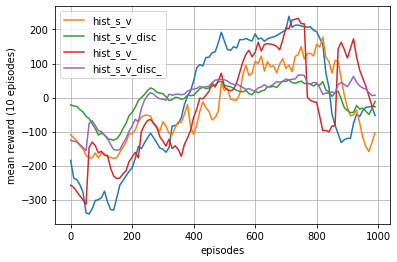

In [11]:
plt.grid(True)
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s[::10],np.ones(10)/10,mode='same'))
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v,np.ones(10)/10,mode='same'),label='hist_s_v')
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v_disc,np.ones(10)/10,mode='same'),label='hist_s_v_disc')
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v_,np.ones(10)/10,mode='same'),label='hist_s_v_')
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v_disc_,np.ones(10)/10,mode='same'),label='hist_s_v_disc_')
plt.xlabel('episodes')
plt.ylabel('mean reward (10 episodes)')
plt.legend()

In [12]:
hist = np.array([[i for i in range(len(hist_s))],hist_s]).T

In [13]:
np.savetxt('st0.txt',hist)